In [1]:
!pip install -Uqq fastbook
import os
import cv2
from google.colab import drive
import fastbook
fastbook.setup_book()
from fastbook import *
import zipfile
import torch
import librosa
import soundfile as sf
from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_videoclips
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from fastai.vision.all import *
drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.5 MB/s eta 0:00:00
Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount

# Step-1: Create audio and video of same duration

In [8]:
# useful functions

def get_audio_info(file_path):
    audio, sr = librosa.load(file_path)
    duration = len(audio) / sr
    return duration

def get_video_info(video_file):
    video = VideoFileClip(video_file)
    duration = video.duration
    fps = fps = video.fps
    resolution = f"{video.size[0]}x{video.size[1]}"
    video.close()
    return duration, resolution, fps

def compare_audio_video(audio_file, video_file):
    video_duration, resolution, fps = get_video_info(video_file)
    audio_duration = get_audio_info(audio_file)

    print("Video Resolution:", resolution, " Video Duration:", video_duration, "seconds", " at fps = ", fps)

    # Compare the durations
    if audio_duration == video_duration:
        print("Audio and video have the same duration which is -> {}.".format(audio_duration))
    else:
        print("Audio and video have different durations where audio is of {} and video is of {}.".format(audio_duration, video_duration))

    return audio_duration, video_duration, fps

def crop_audio(input_file, output_file, start_time, end_time):
    audio, sr = librosa.load(input_file, sr=None)
    start_frame = int(start_time * sr)
    end_frame = int(end_time * sr)
    cropped_audio = audio[start_frame:end_frame]
    sf.write(output_file, cropped_audio, sr)

def crop_video(input_file, output_file, start_time, end_time):
    ffmpeg_extract_subclip(input_file, start_time, end_time, targetname=output_file)

def split_list_into_sequences(lst):
    start_index = []
    end_index = []

    if len(lst) == 0:
        return start_index, end_index

    start = lst[0]
    end = lst[0]

    for i in range(1, len(lst)):
        if lst[i] == end + 1:
            end = lst[i]
        else:
            start_index.append(start)
            end_index.append(end)
            start = lst[i]
            end = lst[i]

    start_index.append(start)
    end_index.append(end)

    return start_index, end_index

def trim_video_and_audio(video_path, audio_path, start_frame, end_frame, output_video_path, output_audio_path):
    video = VideoFileClip(video_path)
    audio = AudioFileClip(audio_path)

    # Calculate start and end times based on frames and frame rate
    frame_rate = video.fps
    print(frame_rate)
    start_time = start_frame / frame_rate
    end_time = end_frame / frame_rate

    # Trim video
    trimmed_video = video.subclip(start_time, end_time)
    trimmed_video.write_videofile(output_video_path, fps=frame_rate)

    # Trim audio
    trimmed_audio = audio.subclip(start_time, end_time)
    trimmed_audio.write_audiofile(output_audio_path)

    video.close()
    audio.close()

def replace_audio(video_file, audio_file, output_file):
    # Load the video clip
    video = VideoFileClip(video_file)

    # Load the audio clip
    audio = AudioFileClip(audio_file)

    # Set the audio of the video clip to the loaded audio clip
    video = video.set_audio(audio)

    # Save the modified video clip with the replaced audio
    video.write_videofile(output_file, codec="libx264", audio_codec="aac")


for (video, audio) in zip(nopoi_video_files, nopoi_audio_files):
    print(video.split('/')[-1], audio.split('/')[-1])
    out = 'NA_'+video.split('/')[-1]

    replace_audio(video, audio, out)


In [9]:
# check if audio and video are of same duration
orig_audio = '/content/gdrive/MyDrive/wav2lip_a/orig_audio.wav'
orig_video = '/content/gdrive/MyDrive/wav2lip_a/orig_720p.mp4'
_, _, _ = compare_audio_video(orig_audio, orig_video)

Video Resolution: 1280x640  Video Duration: 604.81 seconds  at fps =  25.0
Audio and video have different durations where audio is of 67.31755102040816 and video is of 604.81.


In [ ]:
# extract the audio and video for exact consistent duration
start_time = 0
end_time = 67

consist_audio = '/content/gdrive/MyDrive/wav2lip_a/consistent_full_audio.wav'
consist_video = '/content/gdrive/MyDrive/wav2lip_a/consistent_full_video.mp4'

crop_audio(orig_audio, consist_audio, start_time, end_time)
crop_video(orig_video, consist_video, start_time, end_time)

# **Step 2**: Create a Person of Interest (POI) classifier to segment clips having POI, which will be later fed to wav2lip

In [ ]:
# extract frames from video to train an image classifier

# create output directory and set up the process
output_folder_path = '/content/gdrive/MyDrive/wav2lip_a/extracted_frames'
os.makedirs(output_folder_path, exist_ok=True)
video = cv2.VideoCapture(consist_video)

# Start the extraction of frames
frame_count = 0
while True:
    # Read the current frame
    success, frame = video.read()
    if not success:
        break
 # Save the frame as an image
    frame_path = os.path.join(output_folder_path, f'frame_{frame_count}.jpg')
    cv2.imwrite(frame_path, frame)

    frame_count += 1

# Release the video object
video.release()

print(f'{frame_count} frames extracted and saved in {output_folder_path}.')


1675 frames extracted and saved in /content/gdrive/MyDrive/wav2lip_a/extracted_frames.


# **Step 2.1**:  I manually selected 100 images of POI and 100 images of nonpoi from 1 min 7 sec video and uploaded it to the Google drive in 'poi_or_not_v2' folder

In [ ]:
zip_file_path = '/content/gdrive/MyDrive/wav2lip_a/poi_or_not_v2.zip'

# Destination folder to extract the contents
destination_folder = '/content/gdrive/MyDrive/wav2lip_a/'

# Create the destination folder if it does not exist
os.makedirs(destination_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f'ZIP file extracted to {destination_folder}.')


ZIP file extracted to /content/gdrive/MyDrive/wav2lip_a/.


In [ ]:
path = Path('/content/gdrive/MyDrive/wav2lip_a/poi_or_not_v2')
# check if any image file is broken or could not be read by the computer
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

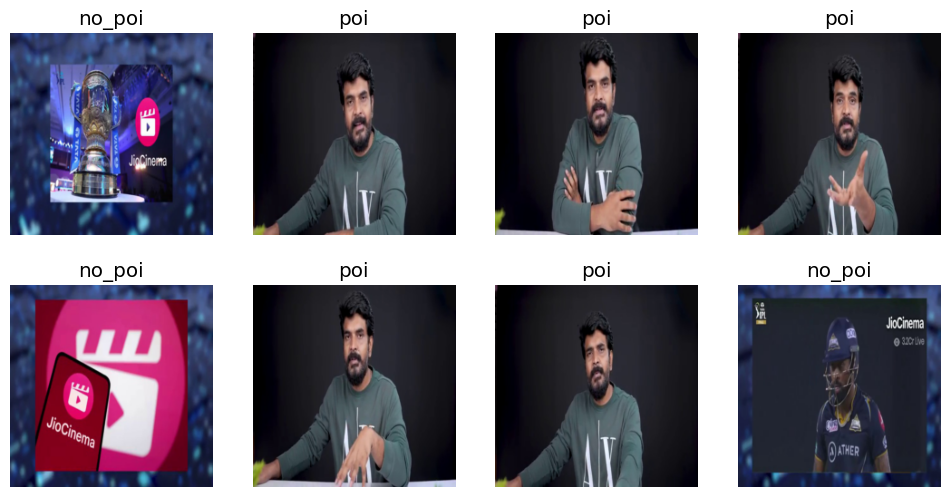

In [ ]:
# create Dataloader to load the images and training the model

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.20, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')]
).dataloaders(path, bs=32)

# let's see some examples
dls.show_batch(max_n=8)

#### **Note**: Ultra fast training in about 10 seconds which creates a perfect classifier. The goal is to automatically segment clips where POI is present so that **unanimated objects don't get animated when using wav2lip**

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.601534,0.003843,0.000000,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.000013,0.000299,0.000000,00:03
1,0.000048,0.000002,0.000000,00:02
2,0.000035,0.000002,0.000000,00:02


In [ ]:
# export the model
learn.export('poi_classifier.pkl')

#### **Step-2.2** Check model accuracy on whole 1675 images: Here I created the dataset where POI was present and not present in the entire whole 1 min 7 sec video containing 1675 frames

In [ ]:
# path to test folder
test_folder_path = Path('/content/gdrive/MyDrive/wav2lip_a/poi_or_not/poi_or_not/')

# Path to the trained model
model_path = '/content/poi_classifier.pkl'

# Load the trained model
learn = load_learner(model_path)

# create dataloader for test and see the performance with confusion matrix
test_files = get_image_files(test_folder_path); print(len(test_files))
test_dl = learn.dls.test_dl(test_files, with_labels=True)
dl = learn.dls.test_dl(test_files, with_labels=True)
interp = ClassificationInterpretation.from_learner(learn, dl=dl)


1675


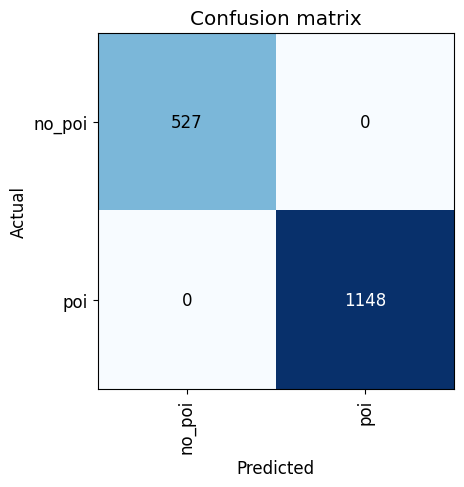

In [ ]:
interp.plot_confusion_matrix()

#### **100% accuracy is achieved by classifier trained in 10 seconds**

# **Step-3**: Segment clips where POI was present and where POI was not present

In [ ]:
import natsort
all_frames = get_image_files(Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames'))
all_frames_sorted = natsort.natsorted(all_frames)
print('Total frames: ', len(all_frames_sorted) )
print(all_frames_sorted[:20])

Total frames:  1675
[Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_0.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_1.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_2.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_3.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_4.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_5.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_6.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_7.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_8.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_9.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_10.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_11.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/extracted_frames/frame_12.jpg'), Path('/content/gdrive/MyDrive/wav2lip_a/

In [14]:
# get all frame indexes with POI and NO POI

poi_ids = []
nonpoi_ids = []
counter = 0
for im in all_frames_sorted:
  class_name, predicted_label, softmax_probs = learn.predict(im)
  if predicted_label == tensor(1):
    poi_ids.append(counter)
  else:
    nopoi_ids.append(counter)
  counter+=1

# get start and end indexes for each video clip
poi_startids, poi_endids = split_list_into_sequences(poi_ids)
print('For POI')
print('start    end')
for (start_frame,end_frame) in zip(poi_startids, poi_endids):
  print(start_frame, '\t', end_frame)

nopoi_startids, nopoi_endids = split_list_into_sequences(nonpoi_ids)
print('\n\nFor NO POI')
for (start_frame, end_frame) in zip(poi_startids, poi_endids):
  print('start    end')
  print(start_frame, '\t',end_frame)

# crop videos for POI and no POI
clips_folder = '/content/gdrive/MyDrive/wav2lip_a/processed_outputs2/'
os.makedirs(clips_folder, exist_ok=True)

i = 1
for (start_frame, end_frame) in zip(poi_startids, poi_endids):
    output_video_path = clips_folder + '{}_poi_720p_vid_{}_{}.mp4'.format(i, start_frame, end_frame)
    output_audio = clips_folder + '{}_poi_aud_{}_{}.wav'.format(i,start_frame, end_frame)
    start_time = start_frame/25.0 # fps=25.0
    end_time = end_frame/25.0
    print(start_frame , end_frame, end_time-start_time)
    trim_video_and_audio(consist_video, consist_audio, start_frame, end_frame, output_video_path, output_audio)
    i+=2

i = 2
for (start_frame, end_frame) in zip(nopoi_startids, nopoi_endids):

    output_video_path = clips_folder + '{}_nopoi_720p_vid_{}_{}.mp4'.format(i,start_frame, end_frame)
    output_audio = clips_folder + '{}_nopoi_aud_{}_{}.wav'.format(i,start_frame, end_frame)
    start_time = start_frame/25.0 # fps=25.0
    end_time = end_frame/25.0
    print(start_frame , end_frame, end_time-start_time)
    trim_video_and_audio(consist_video, consist_audio, start_frame, end_frame, output_video_path, output_audio)
    i+=2



For POI
start    end
0 	 229
551 	 680
768 	 1500
1597 	 1651


For NO POI
start    end
0 	 229
start    end
551 	 680
start    end
768 	 1500
start    end
1597 	 1651


# **Step-4** : Replace audio in NO POI clips

In [ ]:
nopoi_video_files = [os.path.join(clips_folder, file) for file in os.listdir(clips_folder) if 'poi' in file and '.mp4' in file]
nopoi_audio_files = [os.path.join(clips_folder, file) for file in os.listdir(clips_folder) if 'poi' in file and '.wav' in file]
video_folder = 'final/' # create output folder
os.makedirs(video_folder, exist_ok=True)
for (video, audio) in zip(nopoi_video_files, nopoi_audio_files):
  out = video_folder + video.split('/')[-1]
  replace_audio(video, audio, out)




# **Step-5**: Feed POI clips to `Assign_1_102_Wav2lipa.ipynb` with tweaking the parameters

# **Step-6**: Join all the clips

In [14]:
video_list = [os.path.join(video_folder, file) for file in os.listdir(video_folder) if '.mp4' in file]


def join_videos(video_list, output_file):
    video_clips = [VideoFileClip(video) for video in video_list]
    final_clip = concatenate_videoclips(video_clips, method="compose")
    final_clip.write_videofile(output_file, codec="libx264", audio_codec="aac")


output_file_path = "telugu_to_hindi.mp4"

# Join the videos
join_videos(video_list, output_file_path)
